In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv
/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer

In [3]:
path = Path('/kaggle/input/playground-series-s4e2')
original_data = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
train = pd.read_csv(str(path)+'/train.csv')
test = pd.read_csv(str(path)+'/test.csv')

In [4]:
print('shape of dataframe is {}'.format(original_data.shape))
print('shape of dataframe is {}'.format(train.shape))
print('shape of dataframe is {}'.format(test.shape))

shape of dataframe is (2111, 17)
shape of dataframe is (20758, 18)
shape of dataframe is (13840, 17)


In [5]:
original_data.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


In [6]:
train.head(2)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.66995,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.00000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight


In [7]:
train = pd.concat([original_data,train.drop('id',axis=1)])
train.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


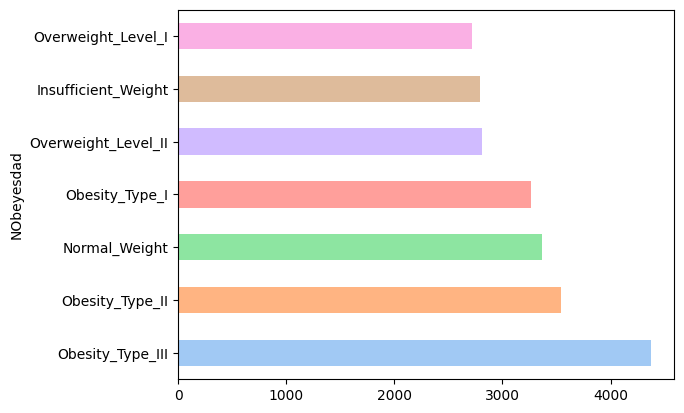

In [8]:
ax = train['NObeyesdad'].value_counts().plot(kind='barh',
                                             color=sns.color_palette('pastel'),
                                             )

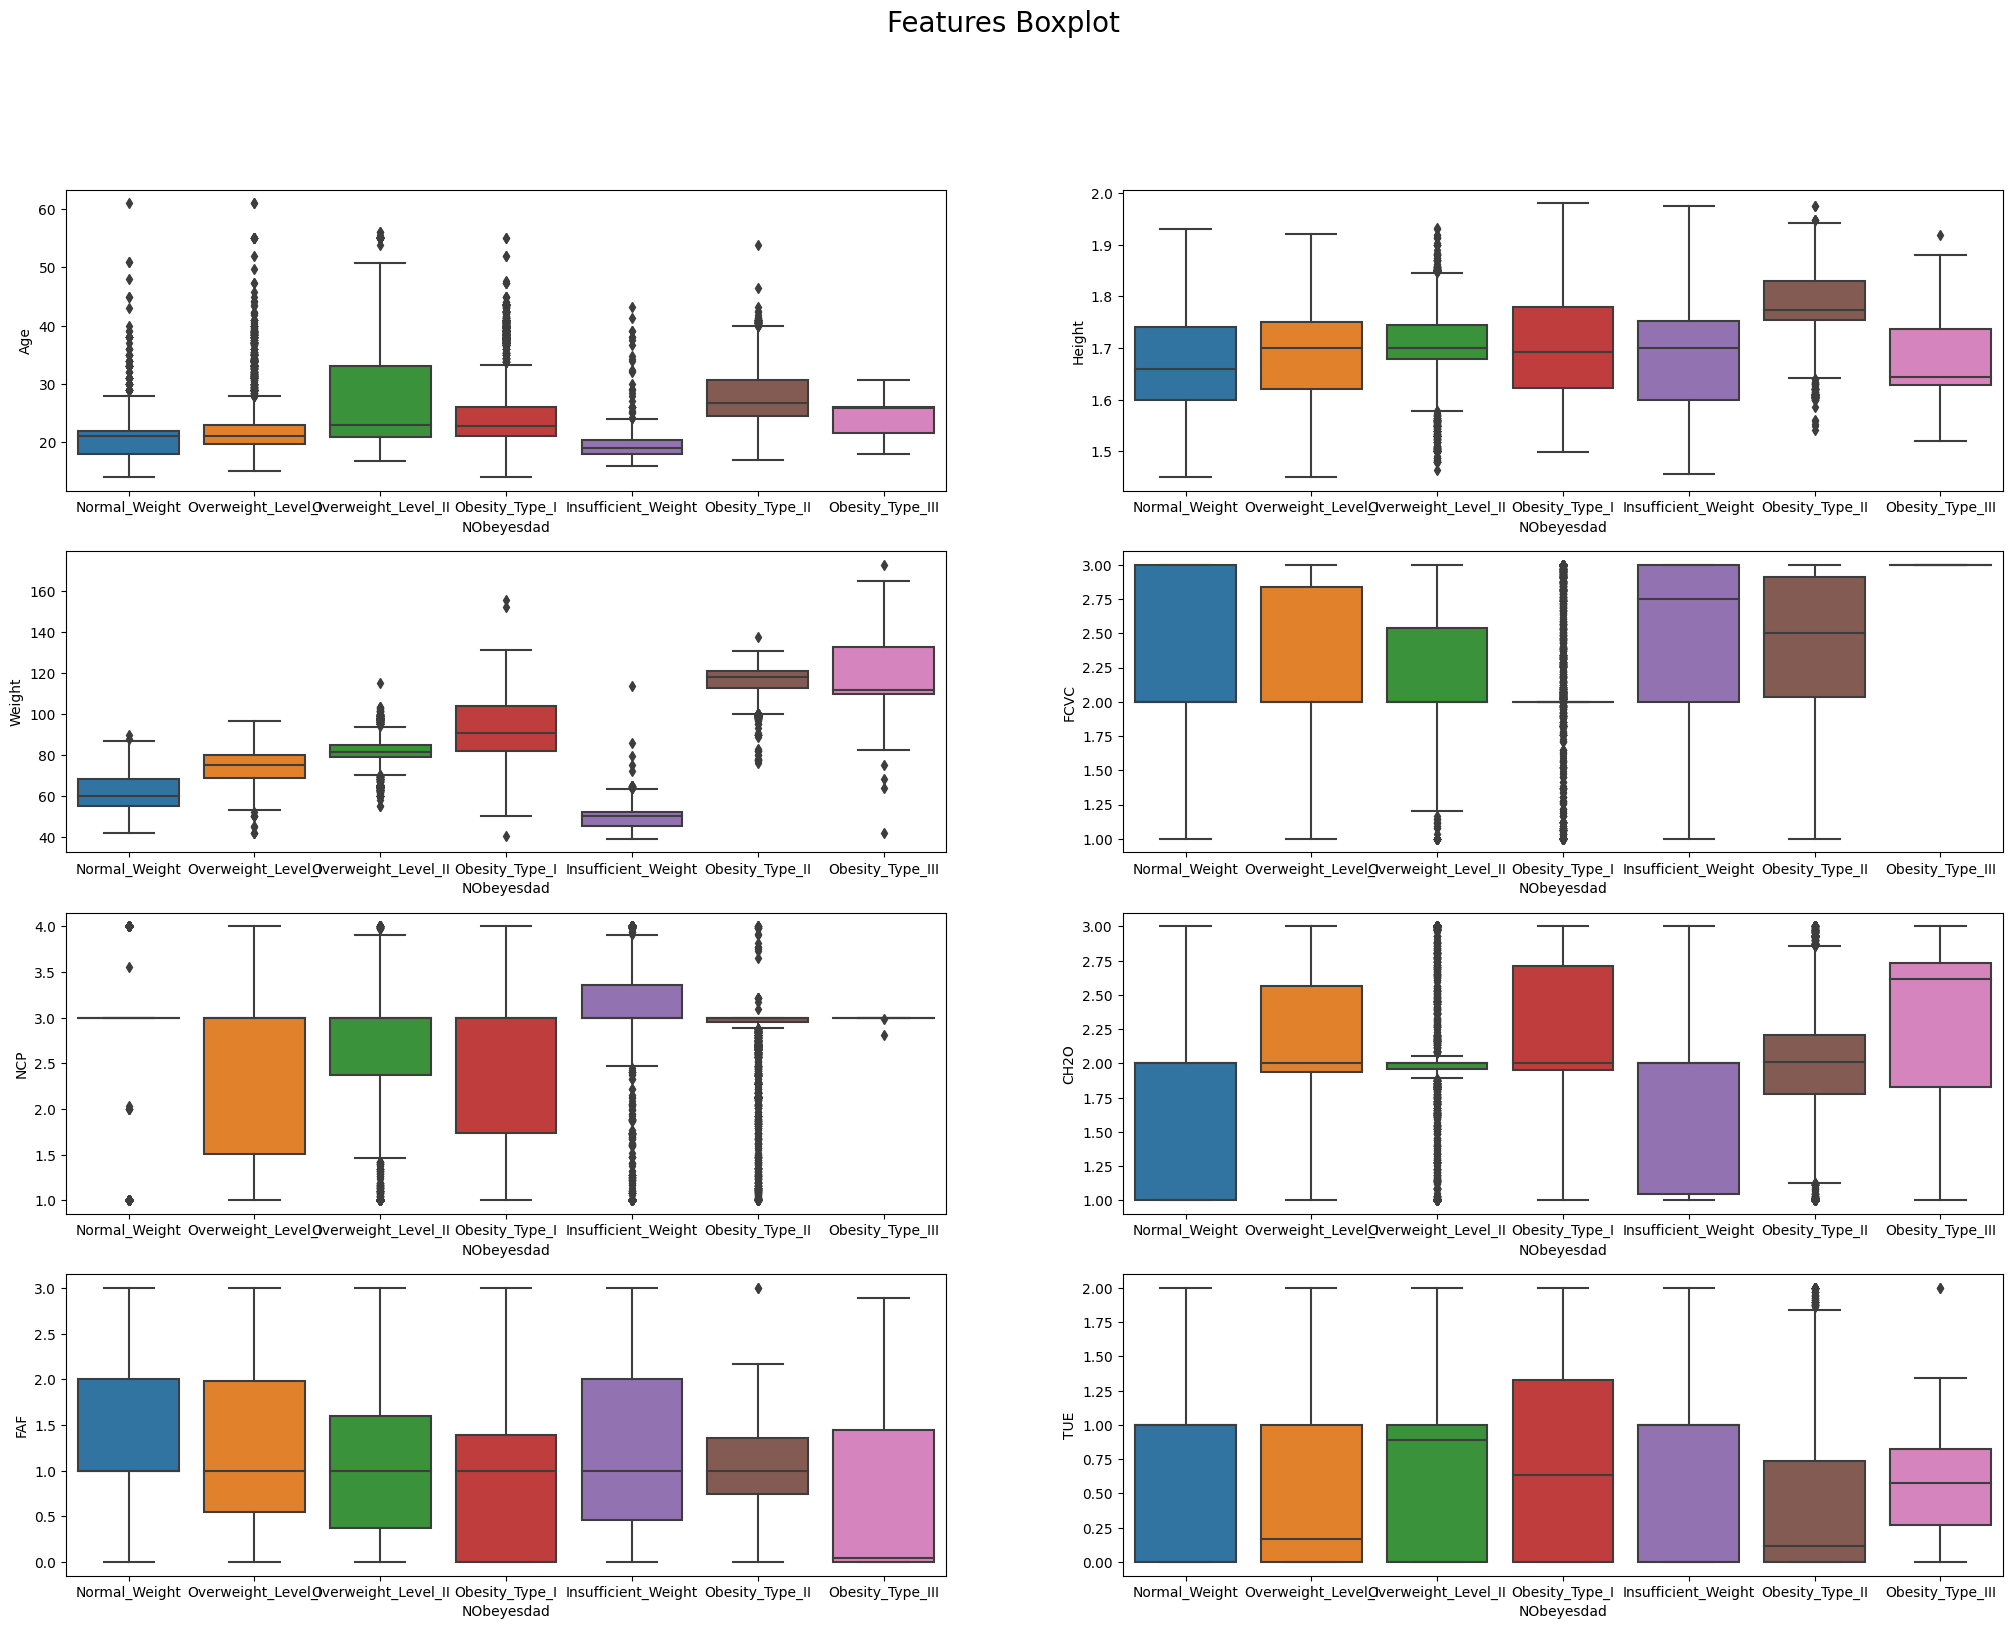

In [9]:
temps = train[['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']]

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(25,18))
fig.suptitle('Features Boxplot',size=20)

for i ,feature in enumerate(temps.columns):
    row,col = divmod(i,2)
    sns.boxplot(x='NObeyesdad',y=feature,data=train,ax=axes[row,col])
    
plt.show()

pre-processing

In [10]:
target = train["NObeyesdad"]
train = train.drop("NObeyesdad", axis="columns")

In [11]:
sorted_labels = ['Insufficient_Weight', 'Normal_Weight', 
 'Overweight_Level_I', 'Overweight_Level_II', 
 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

In [12]:
# thanks to lucamassaron for the idea.
#https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook
from sklearn.base import BaseEstimator, TransformerMixin

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sorted_labels):
        self.classes_ = sorted_labels
        self.label_to_numeric_mapping = None

    def fit(self, y):
        self.label_to_numeric_mapping = {label: numeric for numeric, label in enumerate(self.classes_)}
        return self

    def transform(self, y):
        if self.label_to_numeric_mapping is None:
            raise ValueError("fit method must be called before transform")
        return y.map(self.label_to_numeric_mapping)

    def inverse_transform(self, y):
        if self.label_to_numeric_mapping is None:
            raise ValueError("fit method must be called before inverse_transform")
        return pd.Series(y).map({numeric: label for label, numeric in self.label_to_numeric_mapping.items()})

In [13]:
target_encoder = CustomLabelEncoder(sorted_labels)
target_encoder.fit(target)
target_numeric = target_encoder.transform(target)

In [14]:
class DataPreprocessor:
    def __init__(self,categorical_cols,numeric_cols):
        self.categorical_cols = categorical_cols
        self.numeric_cols  = numeric_cols
        self.encoder = OneHotEncoder(sparse_output=False)
        self.scaler = StandardScaler()
        
        #for training set
    def fit_transform(self, data):
        # OneHotEncoding for categorical columns
        encoded_cols = self.encoder.fit_transform(data[self.categorical_cols])
        encoded_cols = pd.DataFrame(encoded_cols, columns=self.encoder.get_feature_names_out(self.categorical_cols))

        # MinMaxScale for numeric columns
        scaled_cols = self.scaler.fit_transform(data[self.numeric_cols])
        scaled_cols = pd.DataFrame(scaled_cols, columns=self.numeric_cols)

        processed_data = pd.concat([encoded_cols, scaled_cols], axis=1)
        
        return processed_data
    
    #for test set
    def transform(self, data):
        encoded_cols = self.encoder.transform(data[self.categorical_cols])
        encoded_cols = pd.DataFrame(encoded_cols, columns=self.encoder.get_feature_names_out(self.categorical_cols))
        
        scaled_cols = self.scaler.transform(data[self.numeric_cols]) 
        scaled_cols = pd.DataFrame(scaled_cols, columns=self.numeric_cols)
        
        processed_data = pd.concat([encoded_cols, scaled_cols], axis=1)
        
        return processed_data
        


In [15]:
numeric_cols = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
categorical_cols = [x for x in train.columns if x not in numeric_cols]

In [16]:
transform_data = DataPreprocessor(categorical_cols,numeric_cols)

train = transform_data.fit_transform(train)

In [17]:
test = transform_data.transform(test)

In [18]:
X = train
y = target_numeric

In [19]:
params = {
    'n_estimators': 1312,
    'learning_rate': 0.018279520260162645,
    'gamma': 0.0024196354156454324,
    'reg_alpha': 0.9025931173755949,
    'reg_lambda': 0.06835667255875388,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.883274050086088,
    'colsample_bytree': 0.6579828557036317
}

xgb = XGBClassifier(random_state=42, **params)
xgb.fit(X,y)
pred = xgb.predict(test)

In [20]:
print( 'CV score of XGB is',abs(cross_val_score(xgb, X,y,cv = 4, scoring='accuracy').mean()))

CV score of XGB is 0.9158244010380484


In [21]:
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
inverse_pred = target_encoder.inverse_transform(pred)
sample_sub['NObeyesdad'] = inverse_pred
submission = sample_sub.copy()
submission.to_csv("submission.csv", index=False)